In [17]:
from PrimeKG_analysis import *
import sys
sys.path.append('..')
from PrimeKG_utils import *
from embeddings_utils import *

In [2]:
import pandas as pd

primekg_all = pd.read_csv('PrimeKG.csv', low_memory=False)

primekg_all.head()

,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI


In [3]:
# Define 'no_disease' list as the nodes that do not have connection with the disease node
no_genes = ['biological_process', 'molecular_function', 'cellular_component', 'pathway', 'anatomy','effect/phenotype', 'drug','exposure']

# Get the index of rows to drop
rows_to_drop = primekg_all[(primekg_all['x_type'].isin(no_genes)) | (primekg_all['y_type'].isin(no_genes))].index

# Drop the rows from the DataFrame
gene_df = primekg_all.drop(rows_to_drop)

gene_df.head()


,relation,display_relation,x_index,x_id,x_type,x_name,x_source,y_index,y_id,y_type,y_name,y_source
0,protein_protein,ppi,0,9796,gene/protein,PHYHIP,NCBI,8889,56992,gene/protein,KIF15,NCBI
1,protein_protein,ppi,1,7918,gene/protein,GPANK1,NCBI,2798,9240,gene/protein,PNMA1,NCBI
2,protein_protein,ppi,2,8233,gene/protein,ZRSR2,NCBI,5646,23548,gene/protein,TTC33,NCBI
3,protein_protein,ppi,3,4899,gene/protein,NRF1,NCBI,11592,11253,gene/protein,MAN1B1,NCBI
4,protein_protein,ppi,4,5297,gene/protein,PI4KA,NCBI,2122,8601,gene/protein,RGS20,NCBI


In [4]:
# Example: Count distinct values in the 'x_type' column
distinct_count = gene_df['x_type'].unique()
print("Distinct values in 'x_type':", distinct_count)


Distinct values in 'x_type': ['gene/protein' 'disease']


In [6]:
gene_nodes = create_primekg_node_df(gene_df)

In [7]:
n_nodes_type = gene_nodes['node_type'].value_counts()
n_nodes_type

node_type
gene/protein    19054
disease         17099
Name: count, dtype: int64

In [8]:
gene_edges = create_primekg_edge_df(gene_df, gene_nodes)
gene_edges.head()

,relation,display_relation,x_idx,y_idx
0,protein_protein,ppi,0,8889
1,protein_protein,ppi,1,2798
2,protein_protein,ppi,2,5646
3,protein_protein,ppi,3,11592
4,protein_protein,ppi,4,2122


In [9]:
print("Total number of nodes: ", len(gene_edges))
n_edge_type = gene_edges['relation'].value_counts()
n_edge_type

Total number of nodes:  868190


relation
protein_protein    642150
disease_protein    161322
disease_disease     64718
Name: count, dtype: int64

In [10]:
graph = dfs_to_graph_direct_acyclic(gene_nodes, gene_edges)
print(type(graph))
print("directed", graph.is_directed())
print("acyclic", graph.is_acyclic())

<class 'igraph.Graph'>
directed True
acyclic True


In [11]:
avg_path_length = graph.average_path_length()
diameters = graph.diameter()

# Calculate degrees of all nodes
degrees = graph.degree()
average_degree = sum(graph.degree()) / graph.vcount()

print("Average Degree:", average_degree)
print("Avg_path_length:", avg_path_length)
print("diameter:", diameters)

Average Degree: 48.02865598982104
Avg_path_length: 4.890386373814634
diameter: 22


In [12]:
import numpy as np
print(type(degrees))
print("avg", average_degree)
print("q1", np.quantile(degrees,0.25))
print("q2", np.quantile(degrees, 0.5))
print("q3", np.quantile(degrees, 0.75))
print("max", max(degrees))
print("min", min(degrees))

<class 'list'>
avg 48.02865598982104
q1 4.0
q2 14.0
q3 48.0
max 10394
min 2


In [13]:
# Closeness centrality: Average shortest path distance from a vertex to all others
closeness = graph.closeness()

print("avg", np.mean(closeness))
print("q1", np.quantile(closeness,0.25))
print("q2", np.quantile(closeness, 0.5))
print("q3", np.quantile(closeness, 0.75))
print("max", max(closeness))
print("min", min(closeness))

avg 0.2575097371749269
q1 0.23121013811324134
q2 0.26183749166884
q3 0.2882354817614878
max 1.0
min 0.1185012508155711


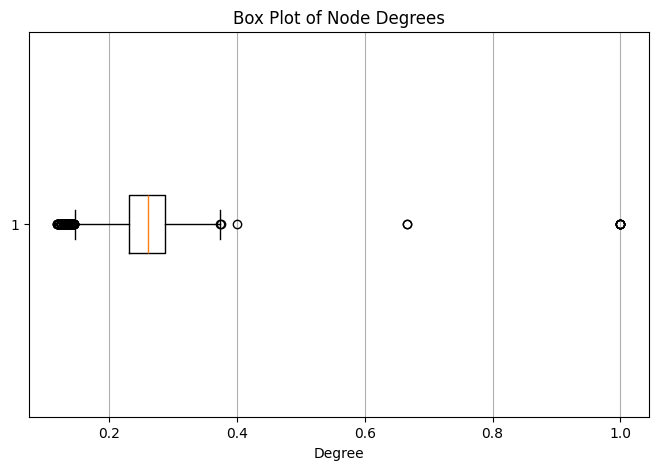

In [14]:
# Create a box plot for the degrees
plt.figure(figsize=(8, 5))
plt.boxplot(closeness, vert=False)
plt.title("Box Plot of Node Degrees")
plt.xlabel("Degree")
plt.grid(True, axis='x')

plt.show()

In [21]:
from embeddings_utils import get_childeren

In [23]:
def get_childeren(G, node_type):
    phenotypes = []
    phenotypes = [node for node in G.vs if node['node_type'] == node_type]

    for node in phenotypes:
        node["children"] = []

        # Populate the "children" attribute with the indices of successor nodes that are in phenotypes
        for succ in G.successors(node.index):  # Use node.index here
            if G.vs[succ] in phenotypes and G.vs[succ]['node_idx'] not in node['children']:  # Check if the successor is also in phenotypes
                node["children"].append(G.vs[succ]["node_idx"])

    return(G)

def get_parents(G, node_type):
    phenotypes = []
    phenotypes = [node for node in G.vs if node['node_type'] == node_type]

    for node in phenotypes:
        node["parents"] = []

        # Populate the "parents" attribute with the indices of successor nodes that are in phe
        for pre in G.predecessors(node.index):  # Use node.index here
            if G.vs[pre] in phenotypes and G.vs[pre]['node_idx'] not in node['parents']:  # Check if the successor is also in phenotypes
                node["parents"].append(G.vs[pre]["node_idx"])
                
    return(G)

from collections import deque

def calculate_nt(G, node_type):
    """
    Calculate n(t) values (disease counts including descendants) for each node
    in a directed acyclic graph, starting from leaf nodes.
    
    Parameters:
        G (igraph.Graph): A directed acyclic graph where nodes may be annotated with diseases.
        
    Returns:
        dict: A dictionary mapping each node_id to its n(t) value.
    """
    # initiate an array of phenotypes
    phenotypes = []
    phenotypes = [node for node in G.vs if node['node_type'] == node_type]

    # step1: find the diseases which are directly annotated to each phenotype node
    annotated_disease(G)

    # find children and parents of each phenotype node
    get_childeren(G, node_type)         
    get_parents(G, node_type)

    # Step 2: Identify leaf nodes with no child
    queue=deque(
        node for node in phenotypes
        if len(node['children']) == 0
    )
    
    # Initialize a visited set to avoid re-processing nodes
    visited = set(queue)

    # Step 3: Bottom-up aggregation of disease counts
    while queue:
        node = queue.pop()

        # Process each parent of the current node
        for parent_idx in node['parents']:
            parent = G.vs[parent_idx]  # Retrieve the parent node object using the index

            if parent not in queue:
                queue.appendleft(parent)            
            
            if parent not in visited:
                for disease in node["annotated_disease"]:
                    if disease not in parent['annotated_disease']:
                        parent['annotated_disease'].append(disease)
            
            # Add parent to the queue if all its children have been processed
            all_children_visited = all(child in visited for child in parent['children'])
            if all_children_visited and parent not in visited:
                visited.appendleft(parent)
    
    # Step 4: Map results to node_id for clarity
    nt_values = {node["node_id"]: len(node["annotated_disease"]) for node in phenotypes}
    
    return nt_values


In [25]:
nt_values_genes = calculate_nt(graph, "gene/protein")


KeyboardInterrupt: 

In [ ]:
# Convert dictionary values to a list
values = list(nt_values_genes.values())

print("len:", len(values))
print("Min:", min(values))
print("Q1:", np.quantile(values, 0.25))
print("Median:", np.median(values))
print("Q3:", np.quantile(values, 0.75))
print("Mean:", np.mean(values))
print("Max:", max(values))

len: 15310
Min: 0
Q1: 0.0
Median: 2.0
Q3: 9.0
Mean: 32.04866100587851
Max: 6065


In [ ]:
zeros = []
for key, value in nt_values_genes.items():
    if value == 0:
        zeros.append(key)

print(len(zeros))
print(zeros)

4951
[938, 1448, 1468, 1475, 1483, 1485, 1486, 1487, 1490, 1491, 1492, 1497, 1498, 1500, 1501, 1502, 1504, 1505, 1523, 1525, 1531, 1532, 1533, 1535, 1537, 1539, 1540, 1544, 1586, 1587, 1591, 1593, 1596, 1597, 1599, 1601, 1602, 1632, 1976, 1994, 2303, 2341, 2506, 2549, 2553, 2559, 2561, 2567, 2571, 2585, 2592, 2594, 2597, 2598, 2599, 2600, 2603, 2604, 2610, 2612, 2613, 2615, 2616, 2626, 2632, 2634, 2644, 2645, 2647, 2648, 2653, 2658, 2661, 2662, 2687, 2693, 2694, 2695, 2697, 2698, 2707, 2708, 2709, 2710, 2711, 2712, 2714, 2716, 2717, 2719, 2720, 2721, 2725, 2727, 2728, 2734, 2735, 2736, 2737, 2739, 2740, 2741, 2743, 2744, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2764, 2765, 2767, 2768, 2786, 2792, 2794, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2817, 2819, 2821, 2824, 2845, 2860, 2863, 2864, 2865, 2878, 2880, 2881, 2890, 2891, 2892, 2893, 2894, 2895, 2897, 2899, 2900, 2901, 2904, 2908, 2909, 2910, 2911, 2912, 2916, 2931, 2932, 2933, 2937, 2939, 2940, 2941, 2942, 2950, 2951, 2952,

In [ ]:
ic_values_genes = calculate_ic_values(graph, nt_values_genes)

In [ ]:
# Convert dictionary values to a list
values = list(ic_values_genes.values())

print("Min:", min(values))
print("Median:", np.median(values))
print("Mean:", np.mean(values))
print("Max:", max(values))

Min: 0.0
Median: 6.856461984594587
Mean: 5.28737549326092
Max: 9.74683374249075


In [ ]:
ic_values_genes

{'HP:0001507': 1.3518081850487211,
 'HP:0000107': 3.26525661321432,
 'HP:0000001': 1.0365439211126006,
 'HP:0000005': 1.2545481867806987,
 'HP:0010460': 4.390247467818739,
 'HP:0000812': 4.494560314444121,
 'HP:0000014': 4.026521965883339,
 'HP:0002719': 2.9567365069768465,
 'HP:0011277': 3.2410496823625228,
 'HP:0008684': 5.2809256238361675,
 'HP:0010936': 5.046353376698335,
 'HP:0000009': 4.548336711224925,
 'HP:0031064': 4.918520005188451,
 'HP:0010955': 6.083272096361105,
 'HP:0010461': 3.44238494006877,
 'HP:0012874': 4.390247467818739,
 'HP:0000135': 3.2637263910335523,
 'HP:0000025': 5.2581973727586115,
 'HP:0008669': 5.6692962985850315,
 'HP:0000035': 3.3532429885401194,
 'HP:0000811': 3.365017725084653,
 'HP:0000062': 5.14166355650266,
 'HP:0000032': 3.475845310632452,
 'HP:0000036': 3.8889005880072918,
 'HP:0000050': 3.7553691953827695,
 'HP:0000045': 4.646967314666552,
 'HP:0003241': 5.73950055725828,
 'HP:0045058': 4.8564846142689975,
 'HP:0008736': 4.033100936981382,
 'HP:

In [ ]:
# Create a box plot for the degrees
plt.figure(figsize=(8, 5))
plt.boxplot(values, vert=False)
plt.title("Box Plot of ic values")
plt.xlabel("ic values")
plt.grid(True, axis='x')

plt.show()